In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [3]:
df = pd.read_hdf('Danionella.h5')


In [4]:
df.head(10)

x         y     theta  tail_angle_01  tail_angle_02  \
frame_id                                                               
305901    354.6027  762.4877  1.688693      -0.057569      -0.098585   
305902    354.7846  762.4101  1.679170      -0.049721      -0.110686   
305903    354.7972  762.2639  1.680839      -0.063216      -0.105089   
305904    354.9238  762.0828  1.677423      -0.060133      -0.113719   
305905    354.8554  762.4290  1.676634      -0.036935      -0.148548   
305906    354.9251  762.2833  1.676751      -0.025943      -0.151010   
305907    354.9701  762.2706  1.679253      -0.029676      -0.154981   
305908    355.0045  762.0753  1.681015      -0.049407      -0.124992   
305909    354.9362  762.7366  1.679855      -0.003576      -0.172042   
305910    354.9089  762.6892  1.683179      -0.021265      -0.109144   

          tail_angle_03  tail_angle_04  tail_angle_05  tail_angle_06  \
frame_id                                                               
305901         0.079641       0.049129      -0.082754      -0.128328   
305902         0.082935       0.060231      -0.066932      -0.100862   
305903         0.083205       0.053699      -0.052808      -0.083353   
305904         0.073875       0.065227      -0.009110      -0.101244   
305905         0.095650       0.001300       0.095087      -0.151557   
305906         0.034835       0.084802       0.017422      -0.076704   
305907         0.040370       0.071754       0.004252      -0.026808   
305908         0.026483       0.080777      -0.039683       0.034957   
305909        -0.014626       0.082224       0.014183       0.051321   
305910        -0.092486       0.054679       0.077161       0.003881   

          tail_angle_07  ...  tail_value_01  tail_value_02  tail_value_03  \
frame_id                 ...                                                
305901        -0.083319  ...       110.2709       107.3225       60.82891   
305902        -0.116938  ...       108.7593       118.9064       71.30074   
305903        -0.116282  ...       112.0417       119.4430       82.47068   
305904        -0.110419  ...       113.9246       124.5385       92.53473   
305905        -0.096062  ...       112.6283       113.8588       97.03622   
305906        -0.084571  ...       116.6183       113.7184       91.00258   
305907        -0.088701  ...       119.7308       112.0695       88.51680   
305908        -0.095538  ...       117.7122       113.0838       84.81815   
305909        -0.101861  ...       127.7499       123.9602       86.90324   
305910        -0.014184  ...       130.2539       107.3957       91.64360   

          tail_value_04  tail_value_05  tail_value_06  tail_value_07  \
frame_id                                                               
305901         90.88052       76.23203       51.16987       44.68130   
305902         84.24125       77.45908       48.44184       46.75766   
305903         82.50231       69.73067       52.13729       47.75901   
305904         83.81439       74.69270       54.38569       47.64020   
305905         96.01034       59.95189       62.38118       45.84756   
305906         97.86189       73.53310       51.08514       49.02306   
305907         88.31061       75.30571       53.76753       52.34233   
305908         80.49852       82.55347       57.28442       52.53932   
305909         71.24934       75.41571       52.09628       47.68031   
305910         72.87362       64.86969       65.13358       45.11681   

          tail_value_08  tail_value_09  tail_value_10  
frame_id                                               
305901         43.60098        0.00000            0.0  
305902         48.87668        3.97171            0.0  
305903         42.42837        0.00000            0.0  
305904         43.64951        0.00000            0.0  
305905         42.23901        0.00000            0.0  
305906         43.50781        0.00000            0.0  
305907         41.39820        0.00000           

In [5]:

def tail_angle_preprocessing(tail_angle,NumSegments=7,BCFilt=10,MinFiltSize=400,MaxFiltSize=20,margin_std=2):
    """ Runs data processing scripts to turn raw data from (../raw) into
        cleaned data ready to be analyzed (saved in ../processed).
    """
    # Smooth Tail angle and compute measure of intensity
    cumul_tail_angle,smooth_cumul_tail_angle,notrack = compute_smooth_tail_angle(tail_angle)
    smooth_tail_speed,speed_tail_angle,super_cumul = compute_tail_speed(smooth_cumul_tail_angle,notrack,NumSegments,BCFilt)
    
    # MinFilt remove unstable baseline & MaxFilt merge bouts
    low_pass_tail_speed,max_filt,min_filt = mexican_hat_tail_speed(smooth_tail_speed,MinFiltSize,MaxFiltSize)
    
    # Compute threshold based on FWHM of speed distribution
    BoutThresh = estimate_speed_threshold(low_pass_tail_speed+1e-6, margin_std,bin_log_min = -5, bin_log_max=5)
    
    # Compute Speed:
    tail_angle_speed = np.zeros_like(smooth_cumul_tail_angle)

    for s in range(tail_angle_speed.shape[1]):
        print(s)
        tail_angle_speed[:,s] = diff_but_better(smooth_cumul_tail_angle[:,s],dt=1/700, filter_length=71)
    
    return smooth_cumul_tail_angle,low_pass_tail_speed,BoutThresh,tail_angle_speed,notrack

In [6]:
def main_segmentation(all_bout_f,tail_angle,tail_angle_speed,Min_Duration = 80,Min_IBI = 10,MinInterPeakDistance = 7,MaxLookahead=5,MaxPercentage=0.3,DiscontinuityPercentage=0.4,StartingIBI=5,NoiseThresh=2):
    

    # Compute Running Average to compute bouts amplitude:
    BCFilt = 50
    ds_ = pd.Series(tail_angle)
    running_avg_tail = ds_.rolling(BCFilt,center=False).mean().values
    detrended_tail_angle= (tail_angle-running_avg_tail)*all_bout_f

    # Find when tail is active:
    onset,offset,duration = find_onset_offset_numpy(all_bout_f==1)
    
    # Refine Segmentation:
    onset_guess, offset_guess, duration, inter_bouts = refine_segmentation_bouts(onset, offset, Min_Duration, Min_IBI)
    onset_guess, offset_guess = onset_guess.tolist(),offset_guess.tolist()
    # Loop over bouts:
    onset,offset = [],[]

    while len(onset_guess)>0:
        #print(len(onset))
        on_ = onset_guess.pop(0)
        off_ = offset_guess.pop(0)
        dur_ = off_-on_
        
        peaks_pos,peaks_neg = find_zeros_crossing(tail_angle_speed[on_:off_])

        # Is there at least an oscillation:
        if is_there_oscillation(peaks_pos,peaks_neg):

            # If two consecutive peaks are closer than <distance> we remove the location corresponding to the smallest value
            peaks_pos = clean_peak_forcing_distance(peaks_pos,tail_angle[on_:off_],Distance=MinInterPeakDistance,sign=1)
            peaks_neg = clean_peak_forcing_distance(peaks_neg,tail_angle[on_:off_],Distance=MinInterPeakDistance,sign=-1)

            # Make Sure all peaks are alternating
            peaks_pos,peaks_neg = clean_peak_forcing_alternation(peaks_pos,peaks_neg,tail_angle[on_:off_])
            # Find the first peak of the bouts (first larger than <percentage> of largest value)
            all_peak = interleave(peaks_pos,peaks_neg)
            
            amplitude = [np.abs(detrended_tail_angle[on_:off_][p]) for p in all_peak]
            #amplitude = [tail_angle[on_:off_][f]-tail_angle[on_:off_][l] for l,f in zip(all_peak[:-1],all_peak[1:])]
            ThreshOnset = MaxPercentage*np.max(np.abs(amplitude[:MaxLookahead]))
            #first_peak_loc = all_peak[1+np.argmax(np.abs(amplitude)>ThreshOnset)]
            first_peak_loc = all_peak[np.argmax(np.abs(amplitude)>ThreshOnset)]
            
            # Remove peak before onset:
            peaks_pos = peaks_pos[peaks_pos>=first_peak_loc]
            peaks_neg = peaks_neg[peaks_neg>=first_peak_loc]
            
            ### Look for abrupt change in periodicity or amplitude
            # Find When Peak to Peak Amplitude 
            if is_there_oscillation(peaks_pos,peaks_neg):
                    
                all_peak = interleave(peaks_pos,peaks_neg)
                
                
                break_in_amplitude,cut = is_break_in_amplitude(tail_angle[on_:off_],all_peak,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)

                if break_in_amplitude:
                    peaks_pos = peaks_pos[peaks_pos<=cut]
                    peaks_neg = peaks_neg[peaks_neg<=cut]

                # Check Discontinuity in interbeat interval:
                break_in_ibi_pos,cut_pos = is_break_in_interbeatinterval(peaks_pos,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)
                break_in_ibi_neg,cut_neg = is_break_in_interbeatinterval(peaks_neg,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)
                if break_in_ibi_pos:
                    peaks_pos = peaks_pos[peaks_pos<cut_pos]
                    peaks_neg = peaks_neg[peaks_neg<cut_pos]
                if break_in_ibi_neg:
                    peaks_pos = peaks_pos[peaks_pos<cut_neg]
                    peaks_neg = peaks_neg[peaks_neg<cut_neg]

                # Split bout'''
                peaks_pos = peaks_pos.tolist()
                peaks_neg = peaks_neg.tolist()
                
             
                # Define Onset and Offset:
                onset.append(on_+min(peaks_pos+peaks_neg))#+ min(peaks_pos+peaks_neg)
                Bout_Duration_FromFirstPeak = max(peaks_pos+peaks_neg) - min(peaks_pos+peaks_neg)
                offset.append(onset[-1]  + max(Min_Duration,Bout_Duration_FromFirstPeak))
                                
                # Is there room for a double bout:
                if (off_ - offset[-1]-5)>Min_Duration:
                    # Introduce New Bouts
                    onset_guess.insert(0,offset[-1]+5) # Introduce a margin between bouts
                    offset_guess.insert(0,off_)
    # Make sure this is not just noise:
    onset_guess,offset_guess = onset,offset
    onset,offset = [],[]
    for on_,off_ in zip(onset_guess,offset_guess):
        if is_there_signal(tail_angle[on_:off_],Thresh=NoiseThresh):
            onset.append(on_)
            offset.append(off_)
            
    return onset,offset


In [7]:
# use tail value as a mask:
tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,11)]]
tail_angle = tail_angle.values


In [8]:
from utils.utils_bouts import diff_but_better,compute_smooth_tail_angle,compute_tail_speed,mexican_hat_tail_speed,estimate_speed_threshold,find_onset_offset_numpy
from utils.utils_beat import refine_segmentation_bouts,find_zeros_crossing,is_there_oscillation,clean_peak_forcing_distance,clean_peak_forcing_alternation,interleave,is_break_in_amplitude,is_break_in_interbeatinterval,is_there_signal

In [9]:
smooth_cumul_tail_angle, low_pass_tail_speed, BoutThresh, tail_angle_speed, notrack = tail_angle_preprocessing(tail_angle,NumSegments=7,BCFilt=10,MinFiltSize=20000,MaxFiltSize=20,margin_std=2)

Shape of No Track:
(11116,)
0
1
2
3
4
5
6
7
8
9


In [10]:

def estimate_speed_threshold(speed,margin_std, bin_log_min = -5, bin_log_max=5 ):
    
    log_speed = np.log(speed)
    count,edge = np.histogram(log_speed,np.arange(bin_log_min,bin_log_max,0.1))
    bins = (edge[:-1]+edge[1:])/2
    # Append Far Value at begining because find_peak does not detect first peak
    count = np.concatenate((np.array([count[-1]]),count))
    peaks = signal.find_peaks(count, distance=5)[0] # distance correspond to 5 bin in log space
    count = count[1:]
    peaks = peaks-1
    # full width at half maximum of the noise peak
    noise_peak_loc = peaks[0]
    # Check if first value above or beyon half max:
    if count[0]>count[noise_peak_loc]/2:
        # Estimate Half Width at half maximum:
        w = np.where(count<count[noise_peak_loc]/2)[0][0]
        fwhm = 2*np.exp(bins[int(np.round(w))])
    else:
        w = np.where(count[noise_peak_loc:]<count[noise_peak_loc]/2)[0][0]
        w = int(w)
        fwhm = 2*np.exp(bins[w])

    sigma = fwhm/2.355 # According to the relation between fwhm and std for gaussian
    BoutThresh = np.exp(bins[noise_peak_loc]) + margin_std*sigma

    return BoutThresh


In [11]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy import stats
def estimate_speed_threshold_using_GMM(speed,margin_std, bin_log_min = -5, bin_log_max=5,axis=None):
    
    log_speed = np.log(speed[speed>0])
    #bin_log_min = -5
    #bin_log_max = 5
    #count,edge = np.histogram(log_speed,np.arange(bin_log_min,bin_log_max,0.1))
    #bins = (edge[:-1]+edge[1:])/2

    X = log_speed[:,np.newaxis]
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)

    weights = gm.weights_
    means = gm.means_
    covars = gm.covariances_

    id = np.argmin(means)
    sigma  = np.sqrt(covars[id]) # Standard Deviation
    BoutThresh = np.exp(means[id] + margin_std*sigma)[0]
    f_axis = log_speed.copy().ravel()
    f_axis.sort()
    if axis is not None:
        axis.hist(log_speed, bins=1000, histtype='bar', density=True, ec='red', alpha=0.1)
        #axis.plot(bins,count)
        axis.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='blue')
        axis.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='blue')
        axis.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel()+weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(),
        c='green')

    return BoutThresh,axis


[0.09491184]


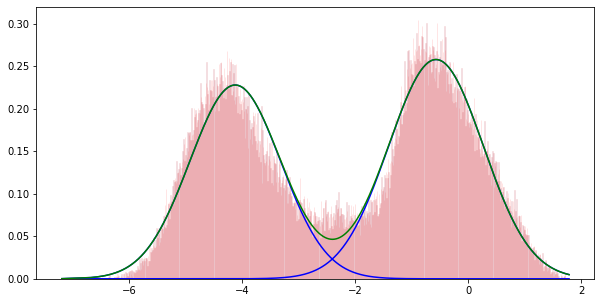

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
BoutThresh,ax = estimate_speed_threshold_using_GMM(low_pass_tail_speed[::100],margin_std=2.2, bin_log_min = -5, bin_log_max=5,axis=ax)
print(BoutThresh)

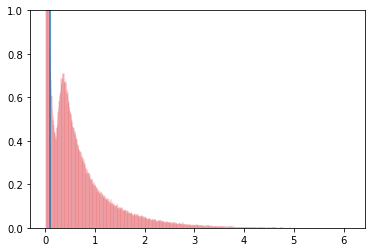

In [13]:
plt.hist(low_pass_tail_speed, bins=1000, histtype='bar', density=True, ec='red', alpha=0.1)
plt.axvline(x=BoutThresh)
plt.ylim(0,1)
plt.show()

In [14]:
BoutThresh

array([0.09491184])

In [15]:
low_pass_tail_speed.shape

(8747873,)

In [16]:
BoutThresh

array([0.09491184])

In [17]:
# 
tail_active = (low_pass_tail_speed>BoutThresh)*1.0
ReferenceSegment=6

onset,offset = main_segmentation(tail_active,smooth_cumul_tail_angle[:,ReferenceSegment],tail_angle_speed[:,ReferenceSegment],Min_Duration = 200,Min_IBI = 10,MinInterPeakDistance = 7,MaxLookahead=10,MaxPercentage=0.3,DiscontinuityPercentage=0.3,StartingIBI=4)

duration = [off_-on_ for on_,off_ in zip(onset,offset)]
print(min(duration))


200


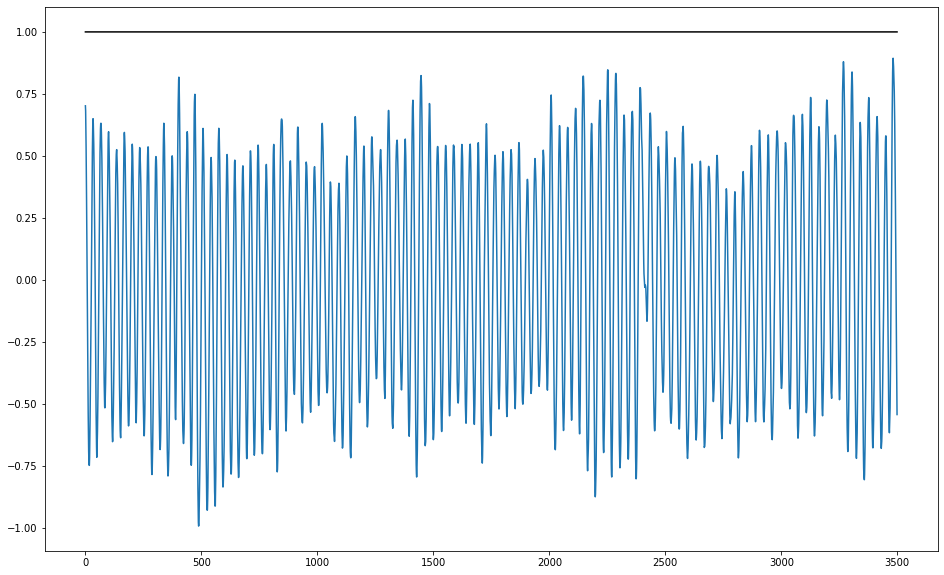

In [18]:
# Diagnostic Plot:
Duration = 700*5
IdSt = 700*60*5
#IdSt = np.random.randint(low_pass_tail_speed.shape[0]-Duration)

fig, (ax1) = plt.subplots(1,1,figsize=(16,10), sharex=True)

ax1.plot(tail_active[IdSt:IdSt+Duration],'k')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
if len(id)>0:
    ax1.scatter(id,smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='b')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
if len(id)>0:
    ax1.scatter(id,smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='r')
ax1.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment])
plt.show()

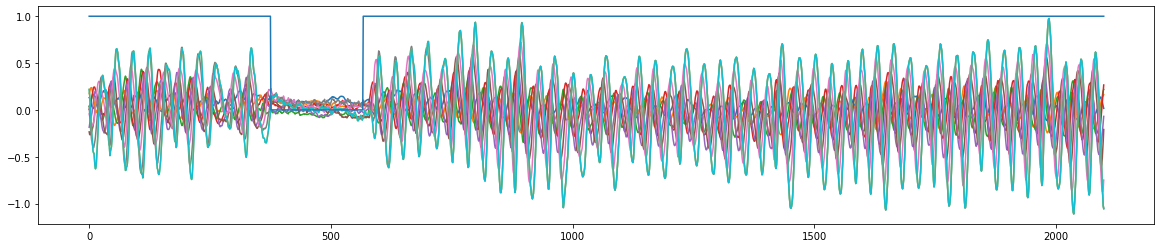

In [19]:
IdSt = np.random.randint(low_pass_tail_speed.shape[0]-Duration)

Duration = 700*3
plt.figure(figsize=(20,4))
plt.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,:])
plt.plot(tail_active[IdSt:IdSt+Duration])

# Using DTW to label bouts

# Using DMD to segment and dissociate signal from noise

In [20]:
smooth_cumul_tail_angle.shape

(8747873, 10)

In [164]:
tail.shape

(500000,)

In [296]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [335]:
# Compute Hankel:
from scipy.ndimage.interpolation import shift

NumSeg = 7
tail = smooth_cumul_tail_angle[:500000,NumSeg]
#tail = tail - np.mean(tail)
tail = tail - moving_average(tail,700*5)
# Low Pass Tail:
tail = tail[:,np.newaxis]





X = np.array([])
X = X.reshape(0,tail.shape[0])
for i in range(0,31,1):
    print(i)
    X = np.concatenate((X,shift(tail,(i,0), cval=0).T))#.reshape(NumSeg,tail.shape[0])))
    
Y = shift(X,(0,-1), cval=0) #36 correspond to average inter-peak distance




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [336]:
# Fit DMD:


In [337]:

def svht(X, sv=None):
    # svht for sigma unknown
    m,n = sorted(X.shape) # ensures m <= n
    beta = m / n # ratio between 0 and 1
    if sv is None:
        sv = scipy.linalg.svdvals(X)
    sv = np.squeeze(sv)
    omega_approx = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
    return np.median(sv) * omega_approx

def dmd_(X, Y, truncate=None):
    if truncate == 0:
        # return empty vectors
        mu = np.array([], dtype='complex')
        Phi = np.zeros([X.shape[0], 0], dtype='complex')
    else:
        U2,Sig2,Vh2 = np.linalg.svd(X, False) # SVD of input matrix
        r = len(Sig2) if truncate is None else truncate # rank truncation
        U = U2[:,:r]
        Sig = np.diag(Sig2)[:r,:r]
        V = Vh2.conj().T[:,:r]
        Atil = U.conj().T.dot(Y).dot(V).dot(np.linalg.inv(Sig)) # build A tilde
        mu,W = np.linalg.eig(Atil)
        Phi = Y.dot(V).dot(np.linalg.inv(Sig)).dot(W) # build DMD modes
    return mu, Phi,U,V,Atil,W,Sig



rank 12


(0.9, 100.0)

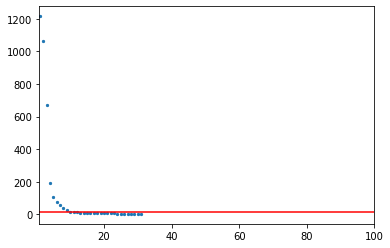

In [338]:
import scipy 
# determine rank-reduction
sv = scipy.linalg.svdvals(X)
tau = svht(X, sv=sv)
r = sum(sv > tau)
print("rank",r)
fig, ax = plt.subplots()
ax.scatter(range(1, len(sv)+1), sv, s=5)
ax.axhline(tau, c='r')
ax.set_xlim([0.9,100])

In [339]:
r = 12

In [340]:
# do dmd
mu, Phi,U,V,Atil,W,Sig = dmd_(X, Y, r)
# compute time evolution
#b = np.dot(np.linalg.pinv(Phi), X[:,0])
Vand = np.vander(mu, np.max(X.shape), True)
#Psi = (Vand.T * b).T

# Analysis of A

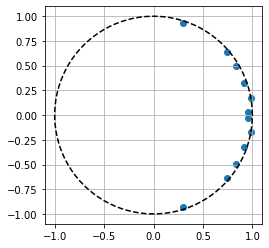

In [341]:
theta = np.linspace(0, 2*np.pi, 100)

radius = 1
a = radius*np.cos(theta)
b = radius*np.sin(theta)

figure, ax = plt.subplots(1)
ax.plot(a, b, '--k')
ax.scatter(np.real(mu), np.imag(mu))
ax.grid()
ax.set_aspect(1)

In [342]:
lambda_ = np.log(mu)/(1/700)

Text(0, 0.5, 'frequency (Hz)')

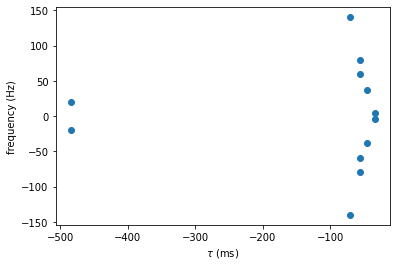

In [343]:
lambda_ = np.log(mu)/(1/700)
plt.scatter(1e3*(1/np.real(lambda_)),np.imag(lambda_)/(2*np.pi))
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel('frequency (Hz)')

Text(0, 0.5, 'frequency (Hz)')

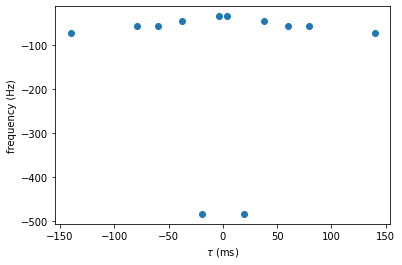

In [344]:
lambda_ = np.log(mu)/(1/700)
plt.scatter(np.imag(lambda_)/(2*np.pi),1e3*(1/np.real(lambda_)),)
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel('frequency (Hz)')

In [345]:
Phi.shape

(31, 12)

In [346]:
r

12

In [347]:
Power = np.power(np.linalg.norm(Phi,axis=0),2)

In [348]:
lambda_ = np.log(mu)
dt = (1/700)
fi = np.imag(lambda_/dt)/(2*np.pi)

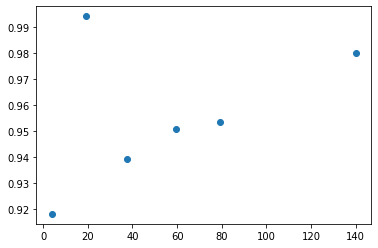

In [349]:
plt.scatter(fi[fi>=0],Power[fi>=0])

# Predict



In [350]:
Phi.shape

(31, 12)

In [351]:
X.shape

(31, 500000)

In [352]:
b = np.dot(np.linalg.pinv(Phi), X)

In [353]:
b.shape

(12, 500000)

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


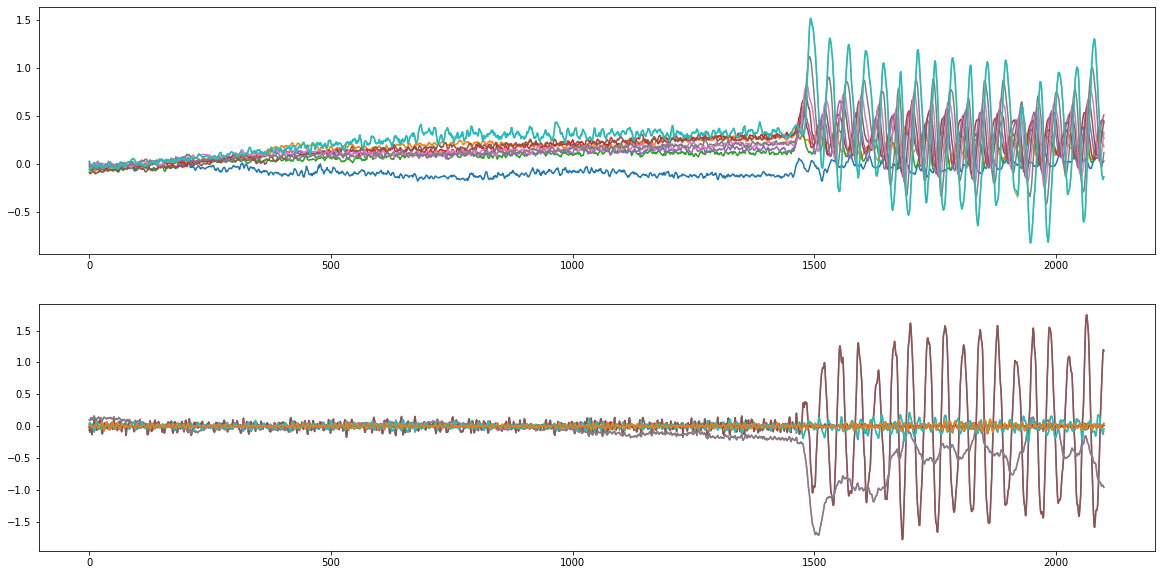

In [354]:
IdSt = np.random.randint(b.shape[1]-Duration)
Duration = 700*3

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(211)
ax1.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,:])

ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(b[:,IdSt:IdSt+Duration].T)

plt.show()

In [355]:
Phi.shape

(31, 12)

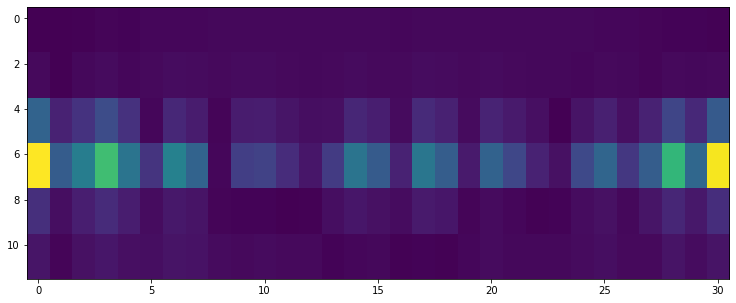

In [356]:
plt.figure(figsize=(15,5))
plt.imshow(np.abs(np.linalg.pinv(Phi)))

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


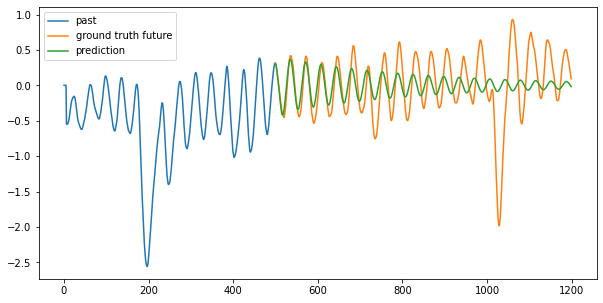

In [357]:
t_ = 500
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


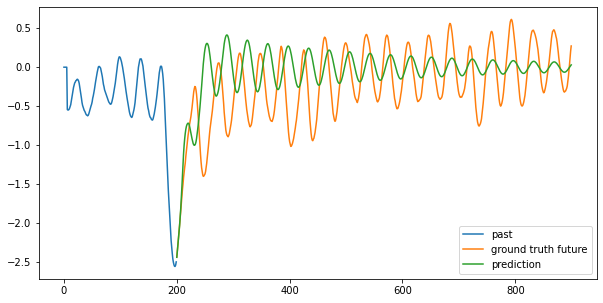

In [358]:
t_ = 200
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


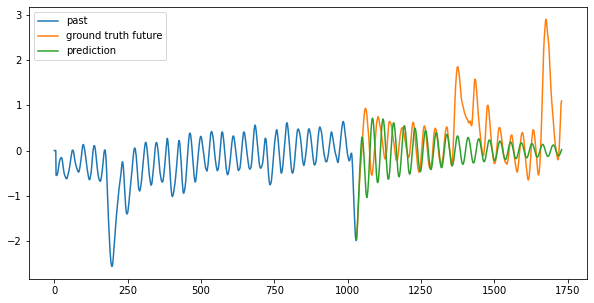

In [359]:
t_ = 1030
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


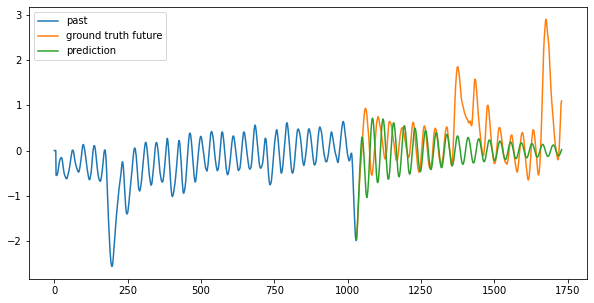

In [372]:
t_ = 1030
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


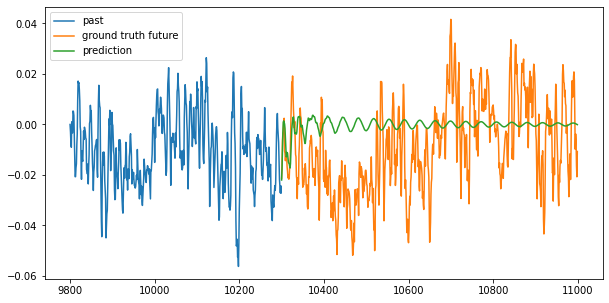

In [373]:
t_ = 10300
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(max(0,t_-500),t_)#np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,max(0,t_-500):t_],label='past')

t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

# Dynamical System in SVD

In [362]:
A_v = np.linalg.inv(Sig).dot(Atil).dot(Sig)

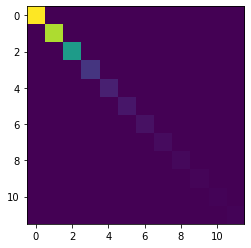

In [363]:
plt.imshow(Sig)

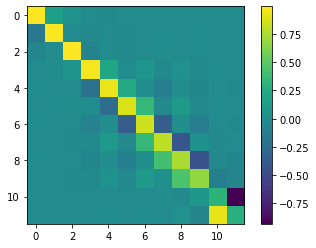

In [364]:
plt.imshow(A_v)
plt.colorbar()

In [365]:
A_v_continuous = (A_v - np.eye(A_v.shape[0]))/dt

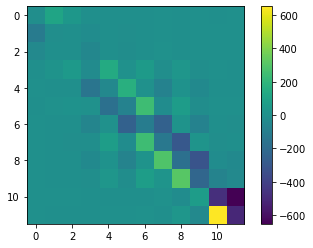

In [366]:
plt.imshow(A_v_continuous,vmin=-np.max(A_v_continuous),vmax=np.max(A_v_continuous))
plt.colorbar()

In [367]:
U.shape

(31, 12)

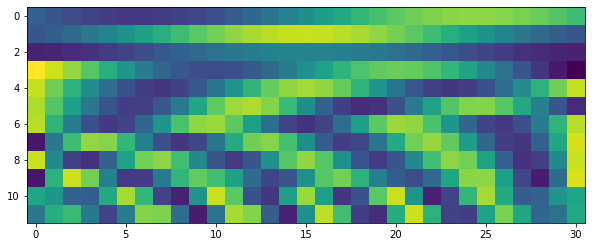

In [368]:
# are U polynomials:
plt.figure(figsize=(10,4))
plt.imshow(U.T)

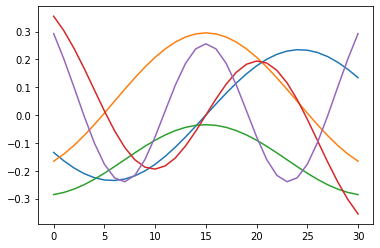

In [369]:
plt.plot(U[:,0:5])

# Using sHAVOK

In [374]:
X.shape

(31, 500000)

In [398]:

import numpy as np
import scipy.io as sio
from scipy import interpolate
from scipy import signal

def sHAVOK(X, dt, r, norm):
    X1 = X[:,:-1]
    X2 = X[:,1:]
    U1,_,Vh1 = np.linalg.svd(X1,full_matrices=False)
    U2,_,Vh2 = np.linalg.svd(X2,full_matrices=False)
    V1 = Vh1.T
    V2 = Vh2.T
    polys = true_polys(X.shape[0], dt, r, center=False)
    for _i in range(r):
        if (np.dot(U1[:,_i], polys[:,_i]) < 0):
            V1[:,_i] *= -1
        if (np.dot(U2[:,_i], polys[:,_i]) < 0):
            V2[:,_i] *= -1
    A = ((V2.T @ V1)[:r,:r] - np.eye(r)) / (norm * dt)
    return A


def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

def reconstruct_v(A, Vh_full, r, dt):
    Ā = A[:-1, :-1]
    B = A[:-1, -1].reshape(-1, 1)
    t0 = np.arange(Vh_full.shape[1]) * dt 
    sys = signal.StateSpace(Ā, B, np.eye(r-1), np.zeros(r-1).reshape(-1, 1))
    tout, y, x = signal.lsim(sys, Vh_full[r-1, :], t0, X0=Vh_full[:r-1, 0])
    Vh_rec = y.T
    return Vh_rec


In [399]:
X.shape

(31, 500000)

In [400]:
r

12

In [401]:
A = sHAVOK(X,1/700,r,norm=1)

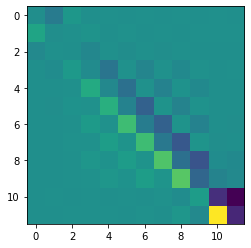

In [402]:
plt.imshow(A)

In [403]:
U,Sig,Vh = np.linalg.svd(X, False) # SVD of input matrix

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


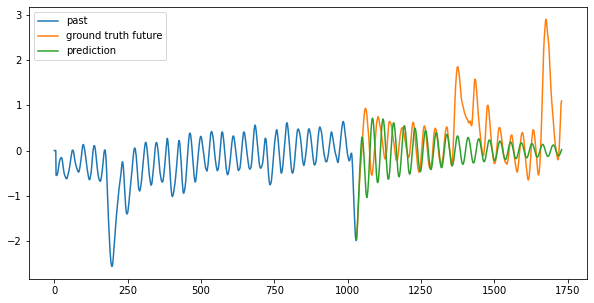

In [404]:
t_ = 1030
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [407]:
Vh.shape

(31, 500000)

In [408]:
r

12

In [412]:
X.shape

(31, 500000)

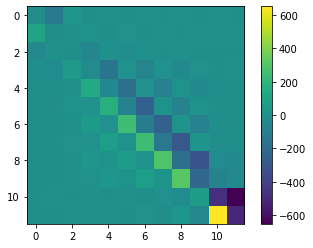

In [424]:
plt.imshow(A)
plt.colorbar()

In [416]:
r

12

In [417]:
A.shape

(12, 12)

In [418]:
B = A[:-1, -1].reshape(-1, 1)

In [421]:
Ā = A[:-1, :-1]

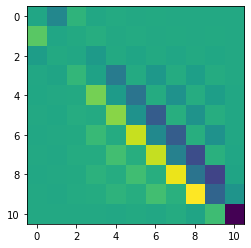

In [422]:
plt.imshow(Ā)

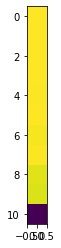

In [423]:
plt.imshow(B)

In [426]:
tmp = reconstruct_v(A,Vh[:,t_:],r,1/700)

In [427]:
tmp.shape

(11, 498970)

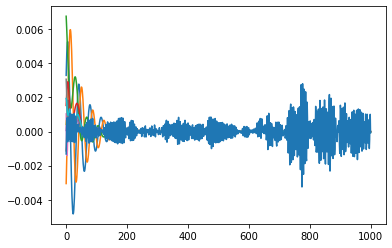

In [433]:
plt.plot(tmp[:,:1000].T)
plt.show()

In [434]:
Vh.shape

(31, 500000)

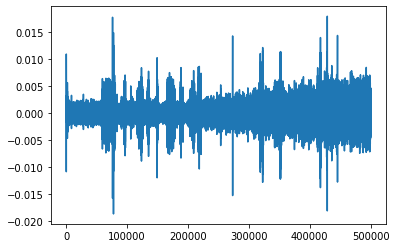

In [435]:
plt.plot(Vh[r-1,:])

In [ ]:

def reconstruct_v(A, Vh_full, r, dt):
    Ā = A[:-1, :-1]
    B = A[:-1, -1].reshape(-1, 1)
    t0 = np.arange(Vh_full.shape[1]) * dt 
    sys = signal.StateSpace(Ā, B, np.eye(r-1), np.zeros(r-1).reshape(-1, 1))
    tout, y, x = signal.lsim(sys, Vh_full[r-1, :], t0, X0=Vh_full[:r-1, 0])
    Vh_rec = y.T
    return Vh_rec


# Compute deviation from prediction:

In [519]:
b = np.dot(np.linalg.pinv(Phi), X)

In [520]:
b.shape

(12, 500000)

In [521]:
Vand = np.vander(mu, np.max(X.shape), True)


In [522]:
Vand.shape

(12, 500000)

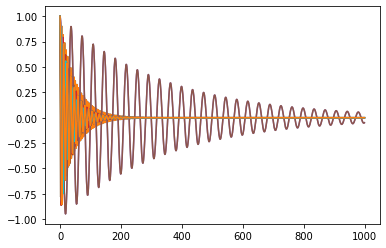

In [523]:
plt.plot(np.real(Vand[:,0:1000].T))
plt.show()

In [524]:
Vand.shape

(12, 500000)

In [547]:
tau = 5
Vand_tau = Vand[:,tau].reshape(-1,1)
Prediction_tau = Phi.dot(Vand_tau*b)

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


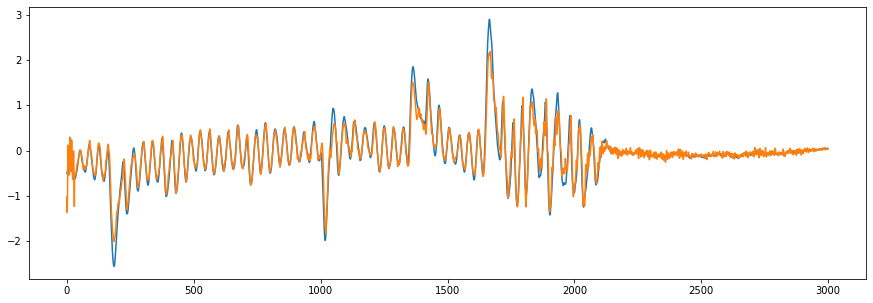

In [548]:

tmp = shift(X[0,:].reshape(1,-1),(0,-tau), cval=0) #36 correspond to average inter-peak distance
plt.figure(figsize=(15,5))
plt.plot(tmp[0,:3000])
plt.plot(Prediction_tau[0,:3000])



In [563]:
# Prediction quality as function of tau:
prediction_error = np.power(Prediction_tau[0,:]-tmp[0,:],2)

In [564]:
prediction_error

array([0.27022755+4.16584691e-15j, 0.78187455+1.24548718e-14j,
       0.30903019+3.84209142e-15j, ..., 0.09322068+9.28977253e-16j,
       0.24112272+2.13279163e-15j, 0.34637879+2.81365183e-15j])

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


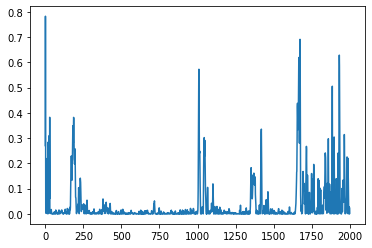

In [567]:
plt.plot(prediction_error[:2000])

In [ ]:
# Error when fish is swimming:

C:\Users\Adrien\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


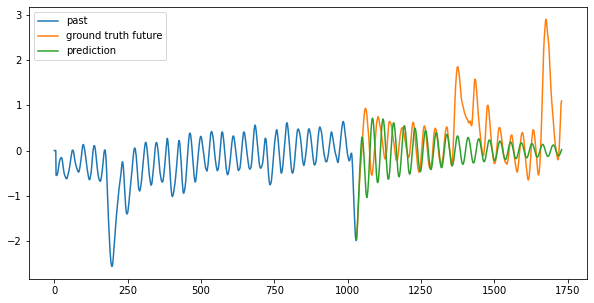

In [489]:
t_ = 1030
b = np.dot(np.linalg.pinv(Phi), X[:,t_])
Vand = np.vander(mu, np.max(X.shape), True)
Psi = (Vand.T * b).T

X_reconstructed = np.dot(Phi, Psi[:,:700])

plt.figure(figsize=(10,5))
s = 6
t_past = np.arange(X[0,:t_].shape[0])
plt.plot(t_past,X[s,:t_],label='past')
t_future = np.arange(t_,t_+700)
plt.plot(t_future,X[s,t_:t_+700],label='ground truth future')
plt.plot(t_future,X_reconstructed[s,:],label='prediction')
plt.legend()

In [490]:
Vand.T.shape

(500000, 12)

In [491]:
b.shape

(12,)

In [492]:
Psi = (Vand.T * b).T


In [493]:
Psi.shape

(12, 500000)

In [494]:
Vand_tau

array([[ 0.36288208+0.03245478j],
       [ 0.36288208-0.03245478j],
       [-0.16274157-0.22952657j],
       [-0.16274157+0.22952657j],
       [-0.62534134+0.59461549j],
       [-0.62534134-0.59461549j],
       [-0.01548687+0.11754238j],
       [-0.01548687-0.11754238j],
       [-0.07569428-0.19361365j],
       [-0.07569428+0.19361365j],
       [-0.02503331+0.27693734j],
       [-0.02503331-0.27693734j]])

In [459]:
b.shape

(12,)

In [460]:
Psi.shape

(12, 500000)

In [461]:
X_reconstructed = np.dot(Phi, Psi[:,:700])


In [462]:
X_reconstructed.shape

(31, 700)